---
# Project 2 - Tracking User Activity
### *By Jyoti Kumari* 

---

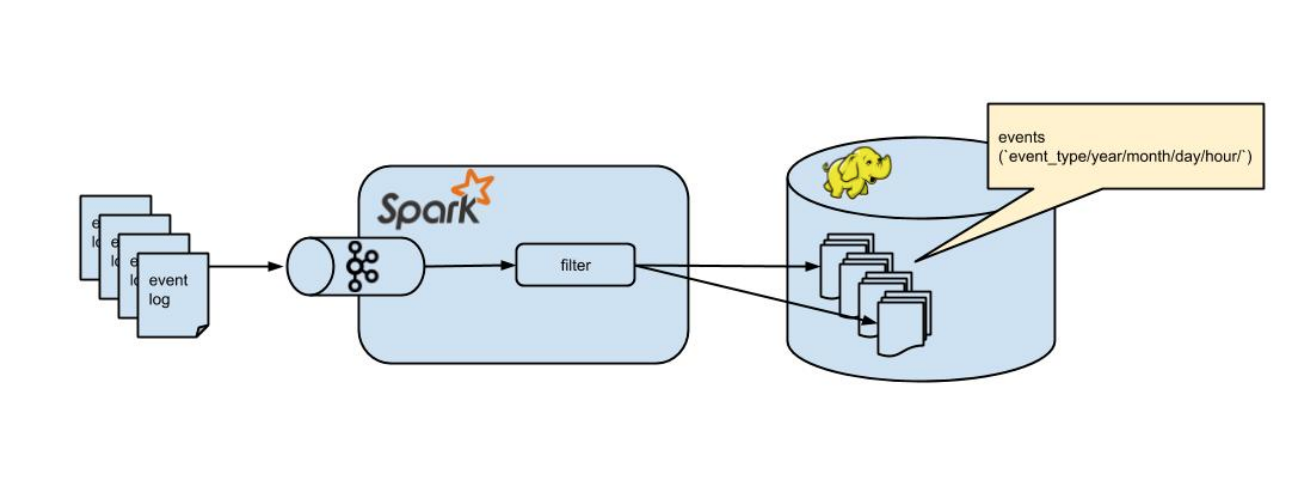

In [20]:
from IPython.display import Image
Image(filename='images/Data pipeline.png')

#### Through this project, we are going to implement 3 major steps:

- Publish and consume messages with Kafka
- Use Spark to transform the messages. 
- Write to HDFS


## 1) Setup

### 1.a. Setting up docker-compose.yml file

#### docker-compose.yml file

```
---
version: '2'
services:
  zookeeper:
    image: confluentinc/cp-zookeeper:latest
    environment:
      ZOOKEEPER_CLIENT_PORT: 32181
      ZOOKEEPER_TICK_TIME: 2000
    expose:
      - "2181"
      - "2888"
      - "32181"
      - "3888"

  kafka:
    image: confluentinc/cp-kafka:latest
    depends_on:
      - zookeeper
    environment:
      KAFKA_BROKER_ID: 1
      KAFKA_ZOOKEEPER_CONNECT: zookeeper:32181
      KAFKA_ADVERTISED_LISTENERS: PLAINTEXT://kafka:29092
      KAFKA_OFFSETS_TOPIC_REPLICATION_FACTOR: 1
    expose:
      - "9092"
      - "29092"

  cloudera:
    image: midsw205/cdh-minimal:latest
    expose:
      - "8020" # nn
      - "50070" # nn http
    #  - "8888" # hue
    #ports:
    #- "8888:8888"

  spark:
    image: midsw205/spark-python:0.0.5
    stdin_open: true
    tty: true
    volumes:
      - ~/w205:/w205
    command: bash
    depends_on:
      - cloudera
    environment:
      HADOOP_NAMENODE: cloudera
    expose:
      - "8888"
    ports:
      - "8888:8888"

  mids:
    image: midsw205/base:latest
    stdin_open: true
    tty: true
    volumes:
      - ~/w205:/w205

```

### 1.b. Pull data for assessment attempts

```
curl -L -o assessment-attempts-20180128-121051-nested.json https://goo.gl/ME6hjp
```

- Unrolling json - Basic Check out on messages

```
docker-compose exec mids bash -c "cat /w205/project-2-jkumariucb/assessment-attempts-20180128-121051-nested.json"
docker-compose exec mids bash -c "cat /w205/project-2-jkumariucb/assessment-attempts-20180128-121051-nested.json | jq '.'"

```

- Individual messages

```
docker-compose exec mids bash -c "cat /w205/project-2-jkumariucb/assessment-attempts-20180128-121051-nested.json | jq '.[]' -c"
```

### 1.c. Spin up the cluster

```
docker-compose up -d
```

```
docker-compose logs -f kafka
```

### 1.d. Check out Hadoop. - look at tmp/ dir in hdfs and see that what we want to write isn't there already.

```
docker-compose exec cloudera hadoop fs -ls /tmp/
```

- At this point, there should not be any files written to HDFS, except the root files.

## 2) Publish and consume messages from Kafka

### 2.a. Create a topic 'assessment'

```
docker-compose exec kafka \
  kafka-topics \
    --create \
	  --topic assessment \
	  --partitions 1 \
	  --replication-factor 1 \
	  --if-not-exists \
	  --zookeeper zookeeper:32181
```

```
- Should see something like

    Created topic "assessment".
    
```

 - What's the name of your Kafka topic? How did you come up with that name?
 
 Since, we have a dataset containing assessments for different exams, I chose my kafka topic name as "assessment"
 

### 2.b Check the topic


```
docker-compose exec kafka \
  kafka-topics \
    --describe \
    --topic assessment \
    --zookeeper zookeeper:32181
```

```

Result:
    
Topic: assessment       PartitionCount: 1       ReplicationFactor: 1    Configs: 
        Topic: assessment       Partition: 0    Leader: 1       Replicas: 1     Isr: 1
```

### 2.c Use kafkacat to produce messages to the "assessment" topic

```
docker-compose exec mids \
  bash -c "cat /w205/project-2-jkumariucb/assessment-attempts-20180128-121051-nested.json \
    | jq '.[]' -c \
    | kafkacat -P -b kafka:29092 -t assessment && echo 'Produced 3280 messages.'"

``` 

```
- Should see something like

    Produced 3280 messages.
```

## 3. Use Spark to transform the messages. 

Step 1. Spin up a pyspark process 

Step 2. continue on spark prompt or use Jupyter notebook and read from Kafka

### 3.a. Spin up a pyspark process using the `spark` container

```
docker-compose exec spark pyspark
```

### Alternative:

- Open jupyter notebook
```
docker-compose exec spark env PYSPARK_DRIVER_PYTHON=jupyter PYSPARK_DRIVER_PYTHON_OPTS='notebook --no-browser --port 8888 --ip 0.0.0.0 --allow-root --notebook-dir=/w205/' pyspark
```

  Copy/paste this URL into your browser when you connect for the first time,
    to login with a token:
        http://0.0.0.0:8888/?token=2e48c921ddb5236e463608bbfbfe7e6f3c51f14c4797c6bf

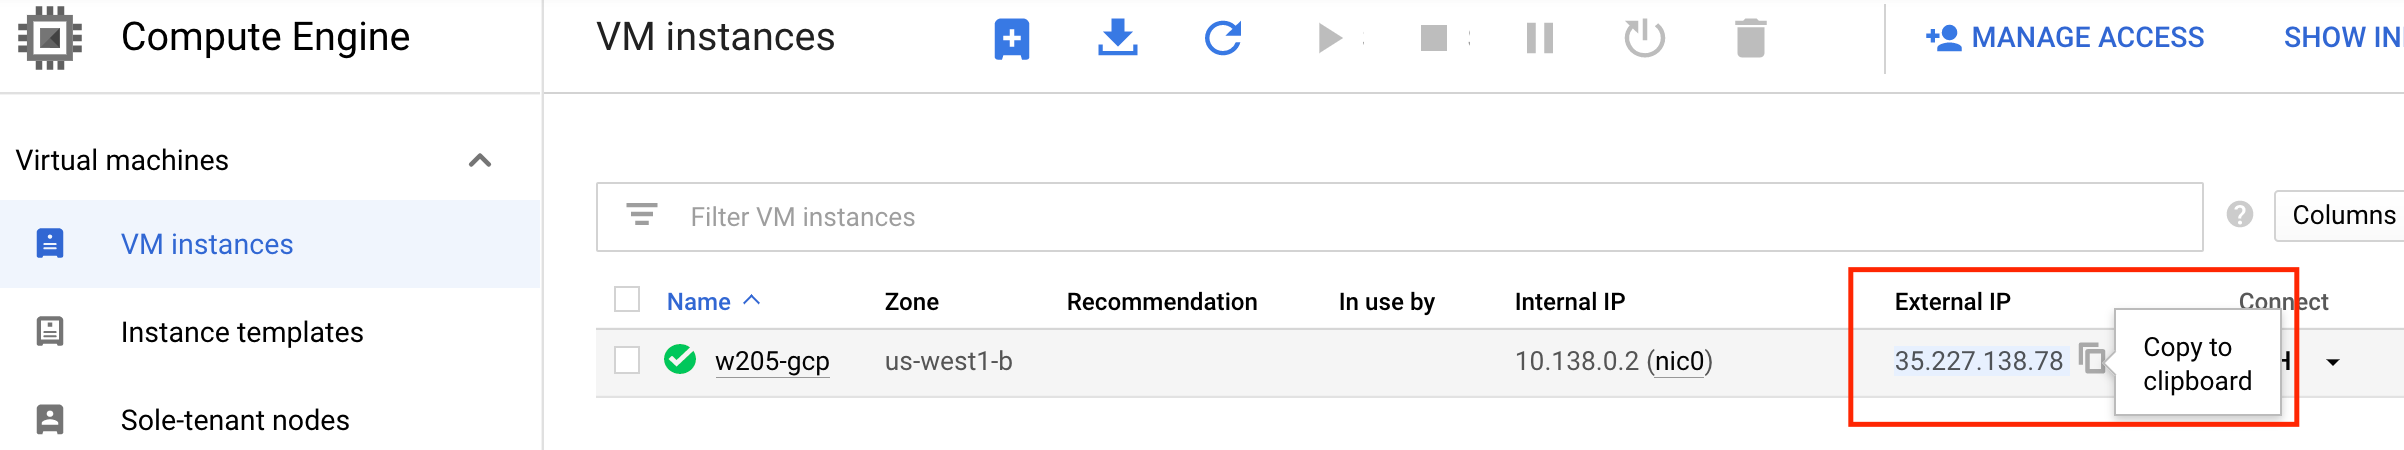

In [25]:
##### Replace token(0.0.0.0) in above link with external IP:

from IPython.display import Image
Image(filename='images/External IP.png')


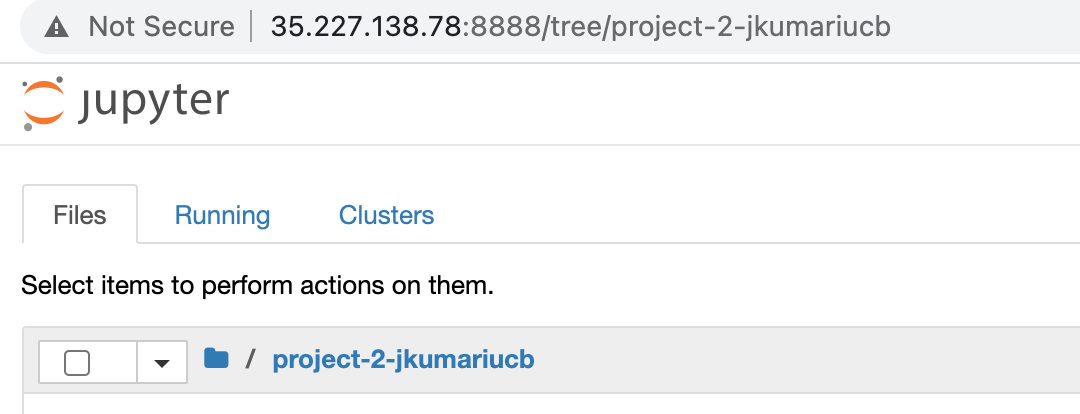

In [26]:
#### Open Jupyter notebook

from IPython.display import Image
Image(filename='images/Jupyter notebook.png')

### For this project, I decided to proceed with spark run through command line

#### Proceeding with pyspark prompt

```
import json
import pandas as pd
from pyspark.sql.functions import explode, split
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType
import warnings
```

### 3.b. Read from kafka

```
raw_assessment = spark \
  .read \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "kafka:29092") \
  .option("subscribe","assessment") \
  .option("startingOffsets", "earliest") \
  .option("endingOffsets", "latest") \
  .load() 
```

### 3.c. Cache this to cut back on warnings later

```
raw_assessment.cache()
```

- See what we got

```
raw_assessment.printSchema()
```

### 3.d. Cast it as strings

```
assessment = raw_assessment.select(raw_assessment.value.cast('string'))
assessment.show(4)
```

### 3.e. Writing to HDFS

```
assessment.write.parquet("/tmp/assessment")
```

- Check out results (from another terminal window)

```
docker-compose exec cloudera hadoop fs -ls /tmp/

and

docker-compose exec cloudera hadoop fs -ls /tmp/assessment/
```

- However, back in the spark terminal window - Let's check what did we actually write?

```
assessment.show(4)

Output

+--------------------+
|               value|
+--------------------+
|{"keen_timestamp"...|
|{"keen_timestamp"...|
|{"keen_timestamp"...|
|{"keen_timestamp"...|
+--------------------+
only showing top 4 rows

```


**Obviously, this is not very readable. 
Here is when we go in and unroll the json. Let's do it all at once, instead of a row at a time**

### 3.f. Extract Data and unroll nested json

- Deal with unicode 

```
import sys
sys.stdout = open(sys.stdout.fileno(), mode='w', encoding='utf8', buffering=1)
```

- What do we have? take a look at:

```
assessment.rdd.map(lambda x: json.loads(x.value)).toDF().show()
```

- To explicitly create `Row` objects from the json fields

```
from pyspark.sql import Row
extracted_assessments = assessment.rdd.map(lambda x: Row(**json.loads(x.value))).toDF()
```

- Save it to HDFS

```
extracted_assessments.write.parquet("/tmp/extracted_assessments")
```

```
extracted_assessments.show(4)

+--------------------+-------------+--------------------+------------------+--------------------+------------------+------------+--------------------+--------------------+--------------------+
|        base_exam_id|certification|           exam_name|   keen_created_at|             keen_id|    keen_timestamp|max_attempts|           sequences|          started_at|        user_exam_id|
+--------------------+-------------+--------------------+------------------+--------------------+------------------+------------+--------------------+--------------------+--------------------+
|37f0a30a-7464-11e...|        false|Normal Forms and ...| 1516717442.735266|5a6745820eb8ab000...| 1516717442.735266|         1.0|Map(questions -> ...|2018-01-23T14:23:...|6d4089e4-bde5-4a2...|
|37f0a30a-7464-11e...|        false|Normal Forms and ...| 1516717377.639827|5a674541ab6b0a000...| 1516717377.639827|         1.0|Map(questions -> ...|2018-01-23T14:21:...|2fec1534-b41f-441...|
|4beeac16-bb83-4d5...|        false|The Principles of...| 1516738973.653394|5a67999d3ed3e3000...| 1516738973.653394|         1.0|Map(questions -> ...|2018-01-23T20:22:...|8edbc8a8-4d26-429...|
|4beeac16-bb83-4d5...|        false|The Principles of...|1516738921.1137421|5a6799694fc7c7000...|1516738921.1137421|         1.0|Map(questions -> ...|2018-01-23T20:21:...|c0ee680e-8892-4e6...|
+--------------------+-------------+--------------------+------------------+--------------------+------------------+------------+--------------------+--------------------+--------------------+
only showing top 4 rows
```

#### We are still getting nested arrays. To deal with the nested array, Use SparkSQL. Let's create a Spark "temptable" (aka "View")

### 3.g. Creating temp table and printing schema:
    
```
extracted_assessments.registerTempTable('assessment')
```


```
extracted_assessments.printSchema()


root
 |-- base_exam_id: string (nullable = true)
 |-- certification: string (nullable = true)
 |-- exam_name: string (nullable = true)
 |-- keen_created_at: string (nullable = true)
 |-- keen_id: string (nullable = true)
 |-- keen_timestamp: string (nullable = true)
 |-- max_attempts: string (nullable = true)
 |-- sequences: map (nullable = true)
 |    |-- key: string
 |    |-- value: array (valueContainsNull = true)
 |    |    |-- element: map (containsNull = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: boolean (valueContainsNull = true)
 |-- started_at: string (nullable = true)
 |-- user_exam_id: string (nullable = true)
 
 ```

#### Check if all the stuff got extracted, since it is a nested json. The answer is a No, we are still getting nested json file

### 3.h. Force the Schema

- In order create the final schema, I am interested in fields such as certification, exam_name, sequences(that is expanded further into counts. Under Counts nested structure, I have used fields such as 'incorrect', 'all_correct', 'correct', 'total'

```
final_schema = StructType([StructField('certification', StringType(), True),
                     StructField('exam_name', StringType(), True),
                     StructField('sequences', StructType([
                         StructField('attempt', StringType(), True),
                         StructField('counts', StructType([
                             StructField('incorrect', StringType(), True),
                             StructField('all_correct', StringType(), True),
                             StructField('correct', StringType(), True),
                             StructField('total', StringType(), True)
                         ]))]))])
   
```


focused_extracted_assessments = assessment.rdd.map(lambda x: json.loads(x.value)).toDF(schema=final_schema)

focused_extracted_assessments.show(5)

focused_extracted_assessments.registerTempTable('focused_assessments')

focused_extracted_assessments.printSchema()

```
>>> focused_extracted_assessments.printSchema()
root
 |-- certification: string (nullable = true)
 |-- exam_name: string (nullable = true)
 |-- sequences: struct (nullable = true)
 |    |-- attempt: string (nullable = true)
 |    |-- counts: struct (nullable = true)
 |    |    |-- incorrect: string (nullable = true)
 |    |    |-- all_correct: string (nullable = true)
 |    |    |-- correct: string (nullable = true)
 |    |    |-- total: string (nullable = true)
 
 ```

- Now, we can start doing more freeform sql.
- using `SparkSQL` will let us easily pick and choose the fields we want to promote to columns.
- We can create Dataframes from queries.

- Basic check:

```
spark.sql("select exam_name, sequences.attempt, sequences.counts.correct from focused_assessments").show(4)

+--------------------+-------+-------+
|           exam_name|attempt|correct|
+--------------------+-------+-------+
|Normal Forms and ...|      1|      2|
|Normal Forms and ...|      1|      1|
|The Principles of...|      1|      3|
|The Principles of...|      1|      2|
+--------------------+-------+-------+
```

## Business Questions

- Grab what we want 

### 1) How many unique assessments are in the dataset?

```
number_of_assessments = spark.sql("select count(distinct(exam_name)) as C from focused_assessments order by C")
number_of_assessments.show()

- Number of assessments in the dataset: 

+---+                                                                           
|  C|
+---+
|103|
+---+
```

### 2) How many people took *Learning Git*?

```
Most_popular_course = spark.sql("select count(*) as count_of_people from focused_assessments where exam_name = 'Learning Git'")
Most_popular_course.show()

- Count of people who took Learning Git as their exam:


+---------------+
|count_of_people|
+---------------+
|            394|
+---------------+
```

### 3) What is the least common course taken?

```
least_common_course = spark.sql("select count(*) as C, exam_name from focused_assessments group by exam_name order by C")
least_common_course.head(4)

The result shows that there are 4 least common course taken - 1 time each.

Those courses are:
- Native Web Apps for Android
- Learning to Visualize Data with D3.js
- Nulls, Three-valued Logic and Missing Information
- Operating Red Hat Enterprise Linux Servers


[Row(C=1, exam_name='Native Web Apps for Android'), Row(C=1, exam_name='Learning to Visualize Data with D3.js'), Row(C=1, exam_name='Nulls, Three-valued Logic and Missing Information'), Row(C=1, exam_name='Operating Red Hat Enterprise Linux Servers')]
```

### 4) What is the most common course taken?

```
most_common_course = spark.sql("select count(*) as C, exam_name from focused_assessments group by exam_name order by C desc")
most_common_course.head(1)


The result shows that the most common course taken is "Learning Git"


[Row(C=394, exam_name='Learning Git')]
```

### 5) Add any query(ies) you think will help the data science team

- **5.a. How many courses provide only 1 attempt for the assessments?**

```
assessment_attempt = spark.sql("select count(*) as Count_of_courses, sequences.attempt from focused_assessments group by sequences.attempt")
assessment_attempt.show()


+----------------+-------+
|Count_of_courses|attempt|
+----------------+-------+
|            3280|      1|
+----------------+-------+

* We can see from the output that all the exams have just 1 attempt, since there are total of 3280 exam names.*
```

- **5.b. Print top 5 exam that has maximum number of questions.**

```
max_number_of_questions = spark.sql("select max(sequences.counts.total) as total, exam_name from focused_assessments group by exam_name order by total desc")
max_number_of_questions.show(5)

+-----+--------------------+                                                    
|total|           exam_name|
+-----+--------------------+
|    8|Learning Linux Sy...|
|    7|Learning to Progr...|
|    7|Being a Better In...|
|    7|Introduction to D...|
|    7|Understanding the...|
+-----+--------------------+

* From this output, we can see that there are different number of questions for different exams.*
```

- **5.c. Find out the average grades for each exam. Print top 5 in descending order.**

```
Average_Grades = spark.sql("select avg(sequences.counts.correct/sequences.counts.total) as grade, exam_name from focused_assessments group by exam_name order by grade desc")
Average_Grades.show(5)

+------------------+--------------------+                                       
|             grade|           exam_name|
+------------------+--------------------+
|               1.0|The Closed World ...|
|               1.0|Learning to Visua...|
|               1.0|Nulls, Three-valu...|
|0.9772727272727273|Learning SQL for ...|
|0.8759493670886073|Introduction to J...|
+------------------+--------------------+
```

- **5.d. Find out if all questions for a given exam has been answered correctly.**

```
Since 'Learning Git' is the most popular course , below query shows the numvber of questions that has been answered correctly for this course.

counts_all_correct = spark.sql("select count(sequences.counts.all_correct) as count, sequences.counts.all_correct, exam_name from focused_assessments where exam_name = 'Learning Git' group by sequences.counts.all_correct, exam_name")
counts_all_correct.show()

+-----+-----------+------------+
|count|all_correct|   exam_name|
+-----+-----------+------------+
|  130|       true|Learning Git|
|  264|      false|Learning Git|
+-----+-----------+------------+

*From the above output, we can clearly see that for the course "Learning Git", there are 130 asessments out of 394 total assessments for this course, that were answered all correct.*
```

## 4) Writing to hdfs - - writing it out to Hadoop

```
number_of_assessments.write.parquet("/tmp/number_of_assessments")

Most_popular_course.write.parquet("/tmp/Most_popular_course")

least_common_course.write.parquet("/tmp/least_common_course")

most_common_course.write.parquet("/tmp/most_common_course")

assessment_attempt.write.parquet("/tmp/assessment_attempt")

max_number_of_questions.write.parquet("/tmp/max_number_of_questions")

Average_Grades.write.parquet("/tmp/Average_Grades")

counts_all_correct.write.parquet("/tmp/counts_all_correct")
```



#### Check out results

- You can see results in hadoop

```
docker-compose exec cloudera hadoop fs -ls /tmp/

and

docker-compose exec cloudera hadoop fs -ls /tmp/assessment/

```


- output

```

jupyter@w205-gcp:~/w205/project-2-jkumariucb$ docker-compose exec cloudera hadoop fs -ls /tmp/
Found 12 items
drwxr-xr-x   - root   supergroup          0 2021-03-15 01:50 /tmp/Average_Grades
drwxr-xr-x   - root   supergroup          0 2021-03-15 01:49 /tmp/Most_popular_course
drwxr-xr-x   - root   supergroup          0 2021-03-14 06:50 /tmp/assessment
drwxr-xr-x   - root   supergroup          0 2021-03-15 01:49 /tmp/assessment_attempt
drwxr-xr-x   - root   supergroup          0 2021-03-15 01:52 /tmp/counts_all_correct
drwxr-xr-x   - root   supergroup          0 2021-03-14 07:03 /tmp/extracted_assessments
drwxrwxrwt   - mapred mapred              0 2018-02-06 18:27 /tmp/hadoop-yarn
drwx-wx-wx   - root   supergroup          0 2021-03-14 05:18 /tmp/hive
drwxr-xr-x   - root   supergroup          0 2021-03-15 01:49 /tmp/least_common_course
drwxr-xr-x   - root   supergroup          0 2021-03-15 01:54 /tmp/max_number_of_questions
drwxr-xr-x   - root   supergroup          0 2021-03-15 01:49 /tmp/most_common_course
drwxr-xr-x   - root   supergroup          0 2021-03-15 01:49 /tmp/number_of_assessments

```


## Exit spark and get spark history

```
ctrl-d

docker-compose exec spark cat /root/.python_history | tee spark_history_jkumari.txt

```

## Bring docker down

```
docker-compose down
```